In [109]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import seaborn as sns
import matplotlib.pyplot as plt
from astropy.table import Table
import copy
from astroduet.models import Simulations
from matplotlib import rcParams
rcParams.update({'font.size': 18})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [111]:
table = Table.read('monte_carlo.csv')

good_chisq = (table['D2_chisq'] < 1e32) & (table['D1_chisq'] < 1e32)
table['good_chisq'] = good_chisq
table['valid_fit'] = (table['D1_chisq'] > 0) & (table['D2_chisq'] > 0) & (table['ngood'] > 5)
table['rejected'] = ~(table['good_chisq']&table['valid_fit'])

# table = table[good]

In [112]:
# table_save = copy.deepcopy(table)
table

fit_model,D1,D2,ratio,D1_chisq,D2_chisq,ratio_chisq,ngood,model,distance,start,end,galaxy,final_resolution,good_chisq,valid_fit,rejected
str17,float64,float64,float64,float64,float64,float64,int64,str17,float64,float64,float64,str18,float64,bool,bool,bool
shock_2.5e10.dat,0.1575365693013032,0.14417728804492436,1.0073825017150748,15.808303649152823,0.024665740761014916,1.8305748403401654,2,kilonova_0.04.dat,173.48980442157955,1800.0,30000.0,none none,1200.0,True,False,True
shock_5e10.dat,0.0716347628733993,0.08154901286060065,1.2240795993699765,9.042036073980247,0.16559692635041862,1.6055380219554947,2,kilonova_0.04.dat,173.48980442157955,1800.0,30000.0,none,1200.0,True,False,True
shock_1e11.dat,0.03584947037041586,0.04956942545841711,1.4405964473569506,4.798089351892612,0.3961597360611264,1.421611798203916,2,kilonova_0.04.dat,173.48980442157955,1800.0,30000.0,none,1200.0,True,False,True
kilonova_0.01.dat,0.42106288032267025,0.3425930705356186,0.8211524728748575,3.0924338281902264,0.6777431979375573,1.4563421432863661,2,kilonova_0.04.dat,173.48980442157955,1800.0,30000.0,none,1200.0,True,False,True
kilonova_0.02.dat,0.3510223887099969,0.2983082985348779,0.8241024764473615,1.3774937237341898,1.1140546787145815,1.4107796547446654,2,kilonova_0.04.dat,173.48980442157955,1800.0,30000.0,none,1200.0,True,False,True
kilonova_0.04.dat,0.3116308447893275,0.273029050804164,0.8221968461807838,0.58168433812461,1.5478598676860211,1.3989743461024418,2,kilonova_0.04.dat,173.48980442157955,1800.0,30000.0,none,1200.0,True,False,True
shock_2.5e10.dat,0.705972184940971,0.6971246370226143,0.7530835023741466,608.1386925670756,136.99228331673197,6.780653449642856,8,shock_1e11.dat,190.63910019063007,1800.0,30000.0,none,1200.0,True,True,False
shock_5e10.dat,0.4209914495777362,0.4204127701117587,0.9024149187195913,135.06331421897045,28.606234956261613,1.6267609985808313,8,shock_1e11.dat,190.63910019063007,1800.0,30000.0,none,1200.0,True,True,False
shock_1e11.dat,0.24622933788642323,0.2555868829498103,1.0424238698591415,2.7065780867096185,2.2229572286911377,0.6548357736036298,8,shock_1e11.dat,190.63910019063007,1800.0,30000.0,none,1200.0,True,True,False


<Figure size 720x576 with 0 Axes>

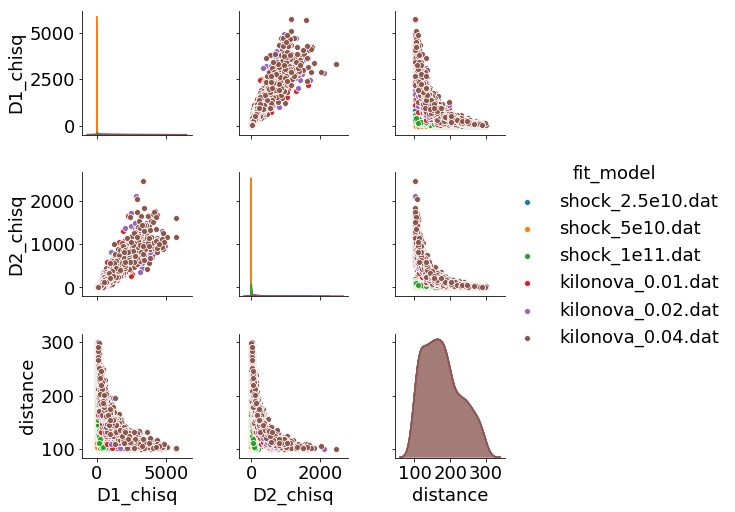

In [113]:
plt.figure(figsize=(10, 8))
sns.pairplot(table[~table['rejected']&(table['model'] == 'shock_5e10.dat')].to_pandas(), 
             hue='fit_model', 
             vars='D1_chisq,D2_chisq,distance'.split(','));

<Figure size 720x576 with 0 Axes>

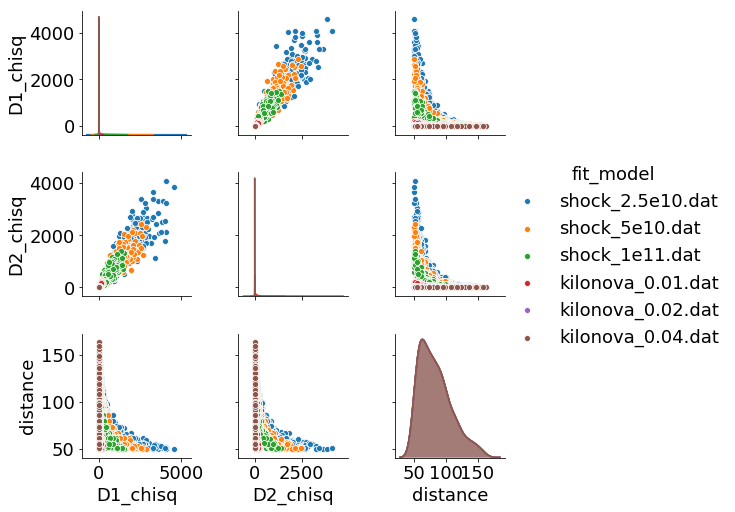

In [114]:
plt.figure(figsize=(10, 8))
sns.pairplot(table[~table['rejected']&(table['model'] == 'kilonova_0.04.dat')].to_pandas(), 
             hue='fit_model', 
             vars='D1_chisq,D2_chisq,distance'.split(','));

<Figure size 720x576 with 0 Axes>

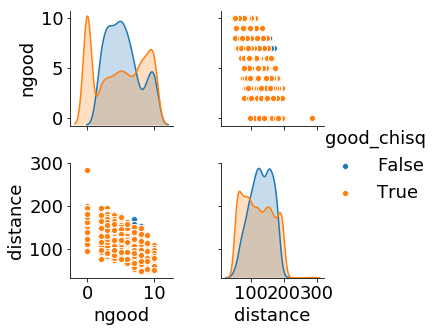

In [115]:
plt.figure(figsize=(10, 8))
sns.pairplot(table[table['model'] == 'kilonova_0.04.dat'].to_pandas(), hue='good_chisq', 
             vars='ngood,distance'.split(','));

<Figure size 720x576 with 0 Axes>

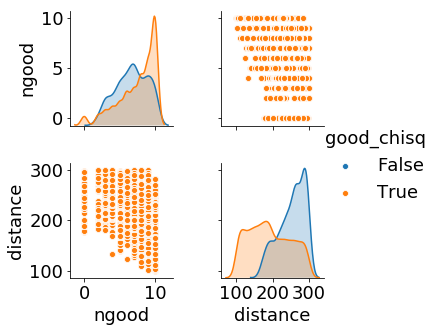

In [116]:
plt.figure(figsize=(10, 8))
sns.pairplot(table[table['model'] == 'shock_5e10.dat'].to_pandas(), hue='good_chisq', 
             vars='ngood,distance'.split(','));

In [117]:
from astropy.table import Table, QTable
from tqdm import tqdm
import numpy as np
def rearrange_table(table_filtered, quantity_to_compare, group_by='distance'):
    t = table_filtered.group_by(group_by)
    standard_quantities = 'model,galaxy,final_resolution,distance,ngood,rejected'.split(',')

    newtable = QTable(t[standard_quantities].groups.aggregate(lambda arr: arr[0]))

    for model_fit in tqdm(Simulations().emgw_simulations):
        values = [sub[quantity_to_compare][sub['fit_model'] == model_fit][0] for sub in t.groups]
        newtable[model_fit] = values
        
    newtable['correct_model'] = 0
    all_models = Simulations().emgw_simulations
    
    best_fit_is_correct = np.zeros(len(newtable), dtype=int)
    for model_fit in tqdm(all_models):
        other_models = [m for m in all_models if m != model_fit]
        print(other_models)
        this_model_is_best = np.ones(len(newtable), dtype=bool)
        for m in other_models:
            this_model_is_best = newtable[model_fit] < newtable[m]
        best_fit_is_correct += this_model_is_best&(model_fit == newtable['model'])

    newtable['correct_model'] = best_fit_is_correct
    return newtable

# table_filtered = table[~table['rejected']]
table_filtered = copy.deepcopy(table)
newtable = rearrange_table(table_filtered, 'D1_chisq')


100%|██████████| 6/6 [00:00<00:00, 1064.41it/s]

['shock_5e10.dat', 'shock_1e11.dat', 'kilonova_0.01.dat', 'kilonova_0.02.dat', 'kilonova_0.04.dat']
['shock_2.5e10.dat', 'shock_1e11.dat', 'kilonova_0.01.dat', 'kilonova_0.02.dat', 'kilonova_0.04.dat']
['shock_2.5e10.dat', 'shock_5e10.dat', 'kilonova_0.01.dat', 'kilonova_0.02.dat', 'kilonova_0.04.dat']
['shock_2.5e10.dat', 'shock_5e10.dat', 'shock_1e11.dat', 'kilonova_0.02.dat', 'kilonova_0.04.dat']
['shock_2.5e10.dat', 'shock_5e10.dat', 'shock_1e11.dat', 'kilonova_0.01.dat', 'kilonova_0.04.dat']
['shock_2.5e10.dat', 'shock_5e10.dat', 'shock_1e11.dat', 'kilonova_0.01.dat', 'kilonova_0.02.dat']


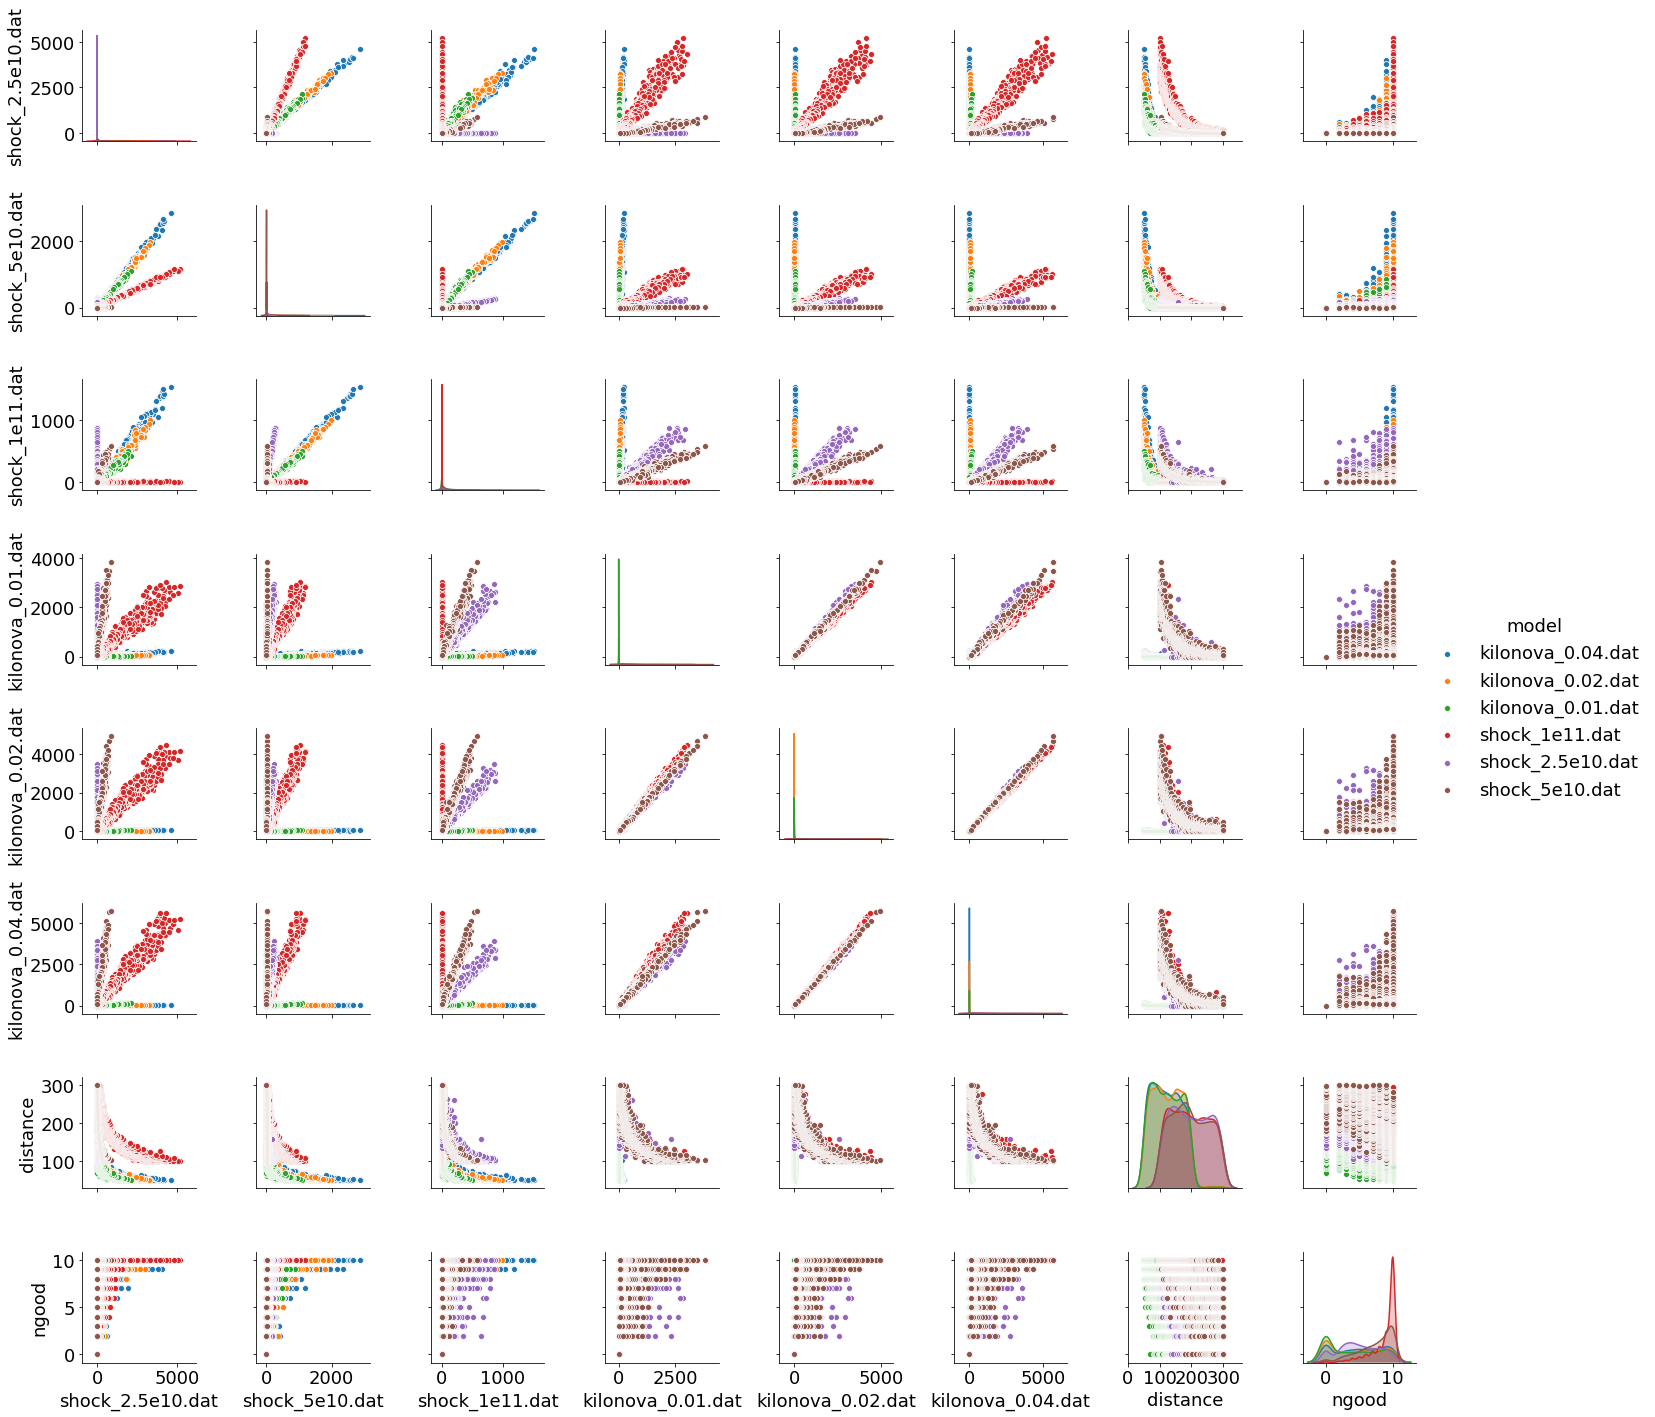

In [118]:
all_models = Simulations().emgw_simulations
sns.pairplot(newtable.to_pandas(), vars=all_models + ['distance', 'ngood'], hue='model')

shock_2.5e10.dat
   Distance: 90 to 110
      Valid points: 99%
      Correct model fit: 100%
   Distance: 110 to 130
      Valid points: 91%
      Correct model fit: 100%
   Distance: 130 to 150
      Valid points: 79%
      Correct model fit: 100%
   Distance: 150 to 170
      Valid points: 63%
      Correct model fit: 100%
   Distance: 170 to 190
      Valid points: 35%
      Correct model fit: 100%
   Distance: 190 to 210
      Valid points: 26%
      Correct model fit: 100%
   Distance: 210 to 230
      Valid points: 17%
      Correct model fit: 100%
   Distance: 230 to 250
      Valid points: 6%
      Correct model fit: 100%
   Distance: 250 to 270
      Valid points: 3%
      Correct model fit: 100%
   Distance: 270 to 290
      Valid points: 2%
      Correct model fit: 100%
   Distance: 290 to 310
All rejected

shock_5e10.dat
   Distance: 90 to 110
      Valid points: 100%
      Correct model fit: 100%
   Distance: 110 to 130
      Valid points: 100%
      Correct model fit: 10

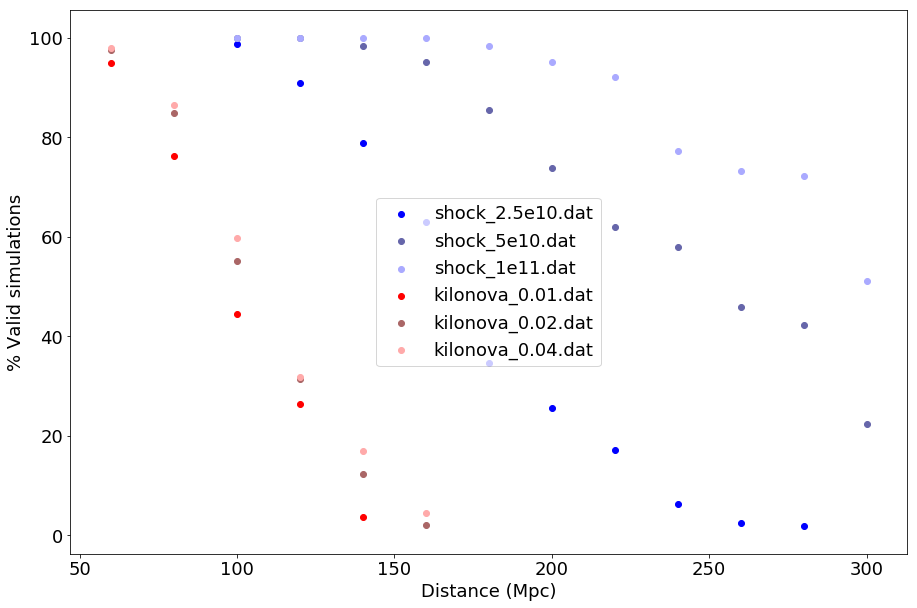

In [119]:
plt.figure(figsize=(15, 10))

colors = ['b', '#6666aa', '#aaaaff', 'r', '#aa6666', '#ffaaaa']
for i, m in enumerate(all_models):
    filt = newtable[newtable['model'] == m]
    label = m
    print(m)
    distances = np.arange(50, 400, 20)
    for distance_intvs in zip(distances[:-1], distances[1:]):
        good_distance = (filt['distance'] >= distance_intvs[0])&(filt['distance'] < distance_intvs[1])
        if not np.any(good_distance):
            continue
        print(f"   Distance: {distance_intvs[0]} to {distance_intvs[1]}")
        good = filt[good_distance]
        not_rejected = ~good['rejected']
        if not np.any(not_rejected):
            print('All rejected')
            continue
        valid = good[not_rejected]
        
        correct_model = valid['correct_model']
        if not np.count_nonzero(correct_model) > 2:
            print("Not enough correct fits")
            continue
        correct = valid[correct_model]
        valid_ratio = len(valid)/len(good)*100
        print(f"      Valid points: {valid_ratio:.0f}%")
        correct_ratio = len(correct) / len(valid)*100.0
        print(f"      Correct model fit: {correct_ratio:.0f}%")
        plt.scatter(np.mean(distance_intvs), valid_ratio, c=colors[i], label=label)
        label=None
        
    plt.xlabel("Distance (Mpc)")
    plt.ylabel("% Valid simulations")
    plt.legend()
        
    print()

In [9]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
ohe = OneHotEncoder(sparse=False)
target = table['model'] == table['fit_model']
table_transformed = ohe.fit_transform(table.to_pandas())


In [10]:
table_transformed

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [1., 0., 0., ..., 1., 1., 0.],
       [0., 1., 0., ..., 1., 1., 0.],
       [0., 0., 1., ..., 1., 1., 0.]])

In [ ]:
# load the iris datasets
dataset = table.pandas()
# create a base classifier used to evaluate a subset of attributes
model = LogisticRegression()
# create the RFE model and select 3 attributes
rfe = RFE(model, 3)
rfe = rfe.fit(dataset.data, dataset.target)
# summarize the selection of the attributes
print(rfe.support_)
print(rfe.ranking_)

In [ ]:
def get_statistics_w_distance(table, model):
    good = table['model'] == model
    